# CH4 Time Series Preprocessing  
**Purpose**: Prepare methane (CH4) data for forecasting using `GasPreprocessor`  

## Workflow  
1. Load cleaned GHG data  
2. Initialize preprocessor  
3. Fit/transform CH4 series  
4. Save processed data  

**Input**: `data/processed/all_ghg_aligned_nan.csv`  
**Output**: `data/processed/ch4_preprocessed.csv`  

[View GasPreprocessor docs](../src/preprocessing.py)  

**Note**: The identical preprocessing will be reapplied to the training set in `4_ch4_modeling.ipynb`  
to avoid data leakage. This full-dataset version is for exploratory purposes only.

In [1]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.preprocessing import GasPreprocessor
print('GasPreprocessor imported sucessfully!')

GasPreprocessor imported sucessfully!


# Load datasets

In [3]:
# load cleaned data (with negative values --> NaN)
df = pd.read_csv(
    '../data/processed/all_ghg_aligned_nan.csv',
    parse_dates=['date'],
    dtype={'CH4': float}
)

print(f'loaded {len(df)} records')
display(df.head())

loaded 2562 records


,date,CH4,CO,CO2,H2,N2O,SF6
0,1969-08-20,NaN,NaN,NaN,NaN,NaN,NaN
1,1969-08-27,NaN,NaN,NaN,NaN,NaN,NaN
2,1969-09-02,NaN,NaN,NaN,NaN,NaN,NaN
3,1969-09-12,NaN,NaN,320.945,NaN,NaN,NaN
4,1969-09-24,NaN,NaN,320.890,NaN,NaN,NaN


# Initialize Preprocessor class

In [4]:
# configure for weekly CH4 data with yearly seasonality
preprocessor = GasPreprocessor(
    gas_name='CH4',
    do_eda=True
)

## CH4 Preprocessing and EDA


[INFO] Fitting preprocessing for CH4
[INFO] Found 136 potential outliers using robust STL residuals.


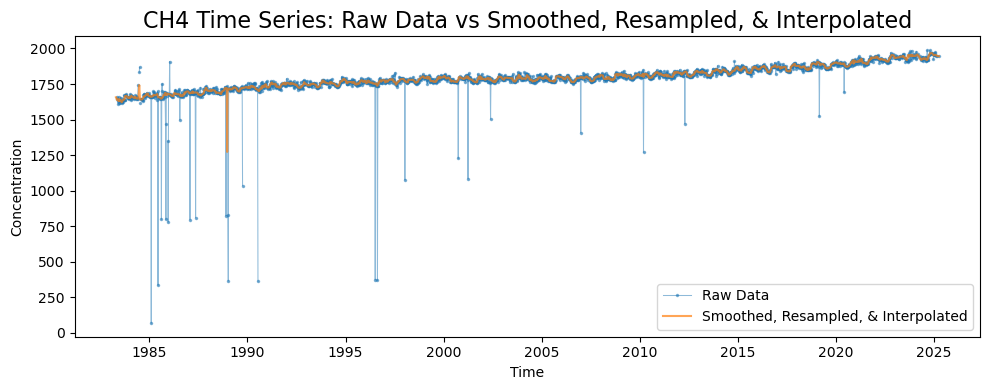

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.9903
ADF p-value 0.7568
ADF critical values: {'1%': -3.433369861402103, '5%': -2.8628740689440835, '10%': -2.5674801917270327}

KPSS statistic 6.9719
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:86: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


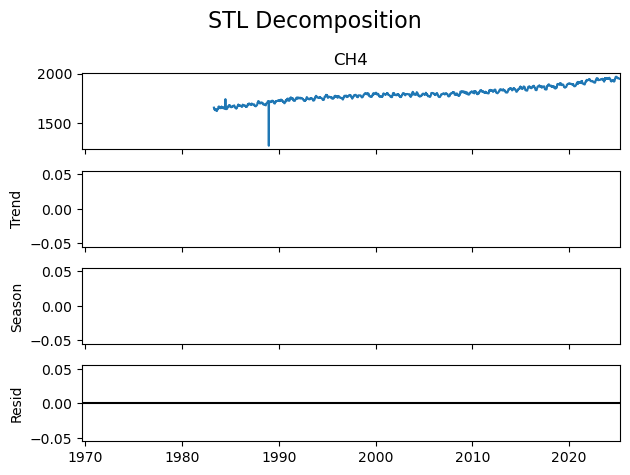

C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\statsmodels\tsa\stattools.py:472: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
C:\Users\aplor\anaconda3\envs\NewEnv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: negative dimensions are not allowed

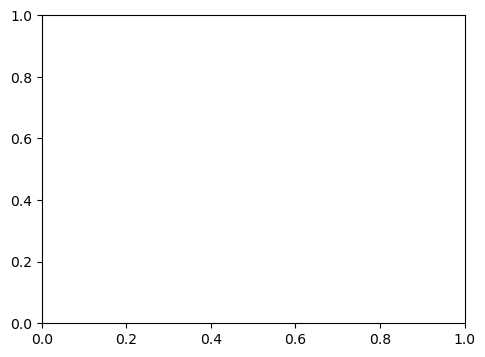

In [5]:
# CH4_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True)
# CH4_preprocessed = CH4_preprocessor.fit_transform(df_combined)

# Run full preprocessing pipeline
ch4_preprocessed = preprocessor.fit_transform(
    df[['date', 'CH4']],
    custom_title='CH4 Time Series: Raw Data vs Smoothed, Resampled, & Interpolated')

# Show results
display(ch4_preprocessed.head())
plt.show()

## CH4 Preprocessing Results Summary

### **Stationarity Analysis**
All processing stages (raw --> smoothed --> resampled) show consistent non-stationarity:
- **ADF Test**: Fails to reject H0 (p > 0.05)  
- **KPSS Test**: Rejects H0 (p < 0.05)  
*Interpretation*: Strong trend dominance persists through preprocessing.

### **STL Decomposition Insights**
| Component | Characteristics | Stationarity |
|-----------|----------------|-------------|
| **Trend** | Smooth monotonic increase | Non-stationary |
| **Seasonal** | ~1-year cycles (constant amplitude) | Stationary |
| **Residuals** | Mean-zero but heteroscedastic | Conditionally stationary |

**Model Type**: Additive (`Y = Trend + Seasonal + Residuals`)

### **Autocorrelation Diagnostics**
- **ACF of Residuals**:  
  - Slow decay --> AR signature  
  - Significant lags at 1-5 (suggest MA(5))  
  - Spike at lag 52 --> Residual seasonality  
- **PACF of Residuals**:  
  - Sharp cutoff after lag 1 --> AR(1) dominant  
  - Marginal significance up to lag 8  

### **Key Implications for Modeling**
1. Required transformations:  
   - **Differencing**: 1st order to address trend  
   - **Seasonal adjustment**: Consider SARIMA terms  
2. Residual patterns suggest:  
   - ARIMA(1,1,5) as starting point  
   - Seasonal periodicity: 52 weeks  
3. Heteroscedasticity may require:  
   - Log transformation or ARCH/GARCH

# Save Preprocessed CH4 Data

In [ ]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

# save metadata
output_path = output_dir / 'ch4_preprocessed.csv'
(
    ch4_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4 preprocessed data saved to:\n{output_path}')
print(f'Shape: {ch4_preprocessed.shape}\nLast 5 records:')
display(ch4_preprocessed.tail())